In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px


data = pd.read_csv(f"newdata_v1.csv")

In [2]:
# main hastags to be used
main_hashtags = ['climatechange',
                'climatecrisis',
                'climatestrikeonline',
                'agw',
                'globalwarming',
                'savetheplanet',
                'climateemergency']

hashtags = []
groups_of_hashtags = [] # needed for #5 to create edges
individual_hashtags = []
for msg in data['Hashtags']:
    hashtags_in_msg = []
    for hashtag in msg.split():
        tag = hashtag.strip('\'.,[]').lower().replace('\\', '').replace('/', '').replace(':', '')
        if "…" not in tag and "http" not in tag:
            hashtags.append(tag)
            hashtags_in_msg.append(tag)
            if tag not in individual_hashtags:
                individual_hashtags.append(tag)
    groups_of_hashtags.append(hashtags_in_msg)
                
# all individual usernumbers per main hashtag
individual_users = dict.fromkeys(main_hashtags, [])

# number of tweets per main hashtag
num_of_tweets = dict.fromkeys(main_hashtags, 0)

# count of individual users per main hashtag
individual_users_count = dict.fromkeys(main_hashtags, 0)

users = data['Username']

for index, tweet_hashtags in enumerate(data['Hashtags']):
    for hashtag in main_hashtags:
        if hashtag in tweet_hashtags:
            num_of_tweets[hashtag] += 1
            if users[index] not in individual_users[hashtag]:
                individual_users[hashtag].append(users[index])
                individual_users_count[hashtag] += 1
                
# print(num_of_tweets)
# print(individual_users_count)


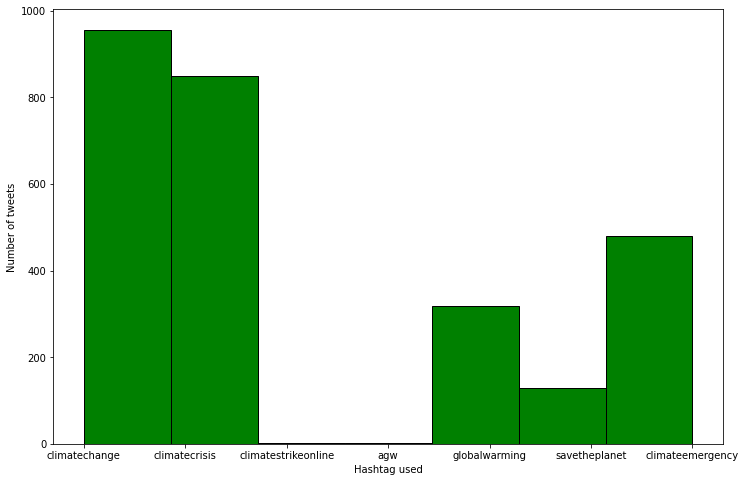

In [3]:
#show number of tweets per hashtag
plt.figure(figsize=(12,8))
number_of_tweets = [key for key, val in num_of_tweets.items() for _ in range(val)]
plt.hist(number_of_tweets, bins=7, color='green',edgecolor='black')
plt.ylabel('Number of tweets')
plt.xlabel('Hashtag used')
plt.show()

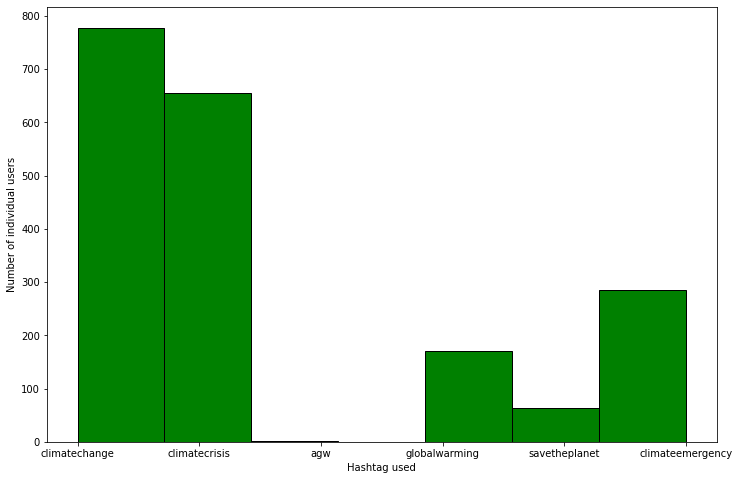

In [4]:
#show number of users per hashtag
plt.figure(figsize=(12,8))
number_of_users = [key for key, val in individual_users_count.items() for _ in range(val)]
plt.hist(number_of_users, bins=7, color='green',edgecolor='black')
plt.ylabel('Number of individual users')
plt.xlabel('Hashtag used')
plt.show()

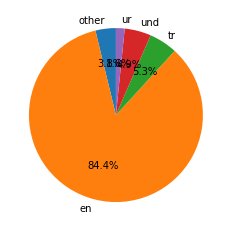

In [5]:


# list of languages in tweets
languages = []
for tweet_lang in data['Language']:
    if tweet_lang not in languages:
        languages.append(tweet_lang)
        
# dict for number of tweets per language
lang_count = dict.fromkeys(languages, 0)

for tweet in data['Language']:
    for lang in languages:
        if lang in tweet:
            lang_count[lang] += 1

# sort dictionary by value
lang_count = dict(sorted(lang_count.items(), key=lambda item: item[1], reverse=True))

# labels dict for showing 5 most popular languages
# init 'other' to prevent keyerror
labels = {'other': 0}

for index, lang in enumerate(lang_count.keys()):
    if index >= 4:
        labels['other'] += lang_count[lang]
    else:
        labels[lang] = lang_count[lang]

fig1, ax1 = plt.subplots()
ax1.pie(labels.values(), labels=labels.keys(), autopct='%1.1f%%', startangle=90)

plt.show()

Loading formatted geocoded file...


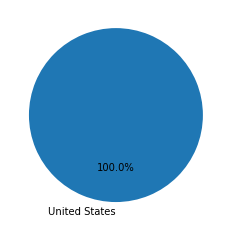

In [6]:
import ast
import reverse_geocoder as rg
import pycountry

#show geographic information of the tweets

countries = {}

for geodata in data['Geo']:
    if type(geodata) != float:
        geodata = ast.literal_eval(geodata)
        if 'coordinates' in geodata:
            latlong = (geodata['coordinates']['coordinates'][1], geodata['coordinates']['coordinates'][0])
            location = rg.search(latlong)
            country = pycountry.countries.get(alpha_2=location[0]['cc']).name
            if country not in countries:
                countries[country] = 1
            else:
                countries[country] += 1
        
fig1, ax1 = plt.subplots()
ax1.pie(countries.values(), labels=countries.keys(), autopct='%1.1f%%', startangle=90)

plt.show()


In [7]:
#vader tool analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
vader_data = []
for sentence in data['Text']:
    vs = analyzer.polarity_scores(sentence)
    vader_data.append(vs)
    #print("{} {}".format(index, vs))
    
fig = px.scatter_ternary(vader_data, a="neg", b="neu", c="pos")
fig.show()

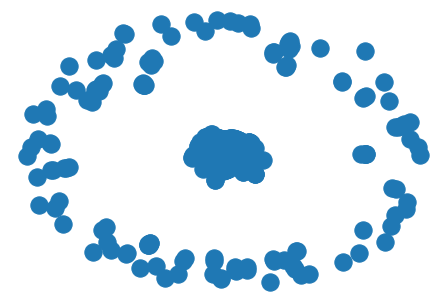

In [8]:
#construct a social graph
import networkx as nx

G = nx.Graph()

adjacent_nodes = {}

for hashtag in individual_hashtags:
    G.add_node(hashtag)

for group in groups_of_hashtags: # groups_of_hashtags is initialized at #1
    for hashtag in group:
        for other_hashtag in group:
            if hashtag != other_hashtag:
                G.add_edge(hashtag, other_hashtag)

nx.draw(G)

In [9]:
#calculate main global properties of the graph
# number of nodes in variable
num_nodes = G.number_of_nodes()
# number of edges in variable 
num_edges = G.number_of_edges()
# degree centrality in a variable
degree_centrality = nx.degree_centrality(G)
degree = nx.degree(G)

# average degree centrality
average_degree_centrality = sum(degree_centrality.values())/num_nodes

try:
        dia = nx.diameter(G)
except nx.NetworkXError:
        dia = "infinite (not connected)"

clustering_coefficient = nx.average_clustering(G)

# size of the largest component
components = [x for x in nx.connected_components(G)]
largest_component = max(components, key=len)

graph_data = {'Number of nodes': num_nodes,
              'Number of edges': num_edges,
              'Average degree centrality': average_degree_centrality,
              'Diameter': dia,
              'Clustering coefficient': clustering_coefficient,
              'Size of largest component': len(largest_component)}

main_properties_dataframe = pd.DataFrame(graph_data, index=['-'])
print(main_properties_dataframe)

   Number of nodes  Number of edges  Average degree centrality  \
-             2128            11887                   0.005252   

                   Diameter  Clustering coefficient  Size of largest component  
-  infinite (not connected)                 0.81233                       1990  


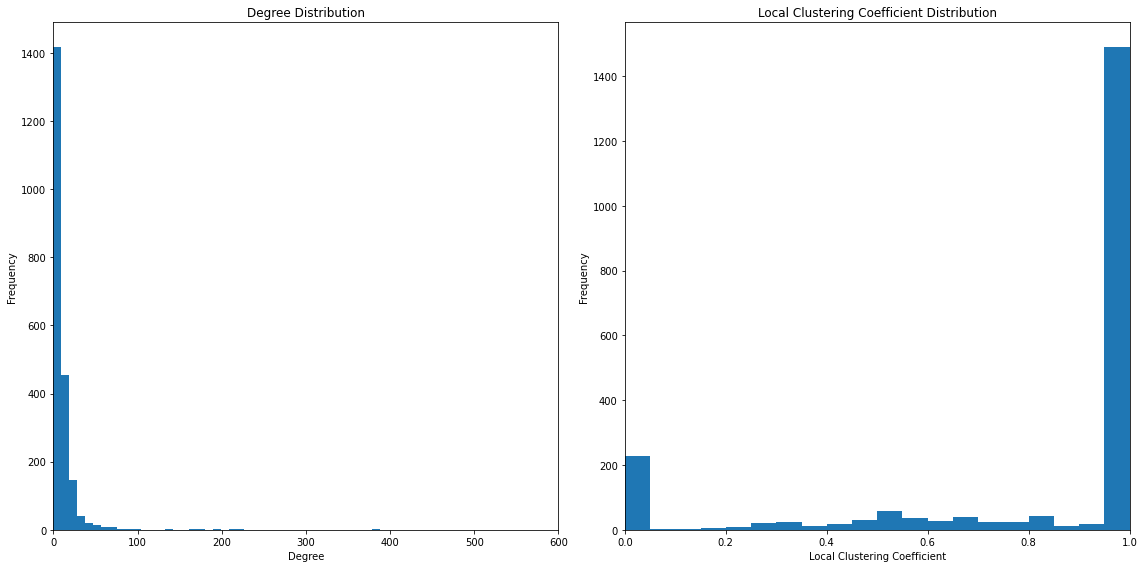

In [10]:

# degree_sequence = sorted(G.degree(), key=lambda x: x[1], reverse=True)
#degree_sequence = sorted(G.degree(), reverse=True)
local_clustering_sequence = sorted(nx.clustering(G).values(), reverse=True)
degrees = [val for (node, val) in sorted(G.degree(), key=lambda pair: pair[0])]

degrees = sorted(degrees)
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
ax1.hist(degrees, label=None, stacked=False, density=False, bins=100)
ax1.set_title("Degree Distribution")
ax1.set_xlabel("Degree")
ax1.set_ylabel("Frequency")
ax1.set_xlim(0, 600)
ax1.tick_params(axis='x', which='minor', bottom=True, labelbottom=False)

ax2 = fig.add_subplot(122)
ax2.hist(local_clustering_sequence, bins=20)
ax2.set_title("Local Clustering Coefficient Distribution")
ax2.set_xlabel("Local Clustering Coefficient")
ax2.set_xlim(0, 1)
ax2.set_ylabel("Frequency")

plt.tight_layout()
plt.show()


In [11]:
# label propagation algorithm for finding communities
communities = nx.algorithms.community.label_propagation.label_propagation_communities(G)
communities = [list(x) for x in communities]

# graph of communities
G_com = nx.Graph()

list_of_community_nodes = []
for group in communities: # groups_of_hashtags is initialized at #1
    for community in group:
        for other_community in group:
            if other_community not in list_of_community_nodes:
                list_of_community_nodes.append(other_community)
                G_com.add_node(other_community)
            if community != other_community:
                G_com.add_edge(community, other_community)

# number of nodes in variable
num_nodes_com = G_com.number_of_nodes()
# number of edges in variable 
num_edges_com = G_com.number_of_edges()

try:
        dia_com = nx.diameter(G_com)
except nx.NetworkXError:
        dia_com = "infinite (not connected)"

clustering_coefficient_com = nx.average_clustering(G_com)

# size of the largest component
components_com = [x for x in nx.connected_components(G_com)]
largest_component_com = max(components_com, key=len)


data = {'Number of nodes': num_nodes_com,
        'Number of edges': num_edges_com,
        'Diameter': dia_com,
        'Clustering coefficient': clustering_coefficient_com,
        'Size of largest component': len(largest_component_com)}

main_properties_dataframe = pd.DataFrame(data, index=['-'])
print(main_properties_dataframe)

   Number of nodes  Number of edges                  Diameter  \
-             2128          1006729  infinite (not connected)   

   Clustering coefficient  Size of largest component  
-                0.930451                       1418  


In [15]:
#task 10: rank tweets according to the number of likes and retweets
tweet_score_rankings = []

#initialize list for calculating rankings
for tag in individual_hashtags:
    tweet_score_rankings.append((tag, 0))
    
#check max likes and numbers
max_like = max(data['Likes'])
max_retweet = max(data['Retweets'])


for index, tags in enumerate(data['Hashtags']):
    #calculate relative score
    likes = data['Likes'][index] /max_like
    retweets = data['Retweets'][index]/max_retweet
    final_score = likes+retweets
    
    #loop through the hashtags in this tweet
    for tag in tags.split():
        #clean the tag
        tag = tag.strip('\'.,[]').lower().replace('\\', '').replace('/', '').replace(':', '')
        
        #add new score to all hashtags that were included in this tweet
        for j, one_tag in enumerate(tweet_score_rankings):
            if tweet_score_rankings[j][0] == tag:
                tweet_score_rankings[j] = (tweet_score_rankings[j][0], tweet_score_rankings[j][1]+final_score)

#sort the ranking list
sorted_rankings = sorted(tweet_score_rankings, key=lambda tup: tup[1], reverse=True)

#50 best ranked tweets
for i in range(50):
    print(sorted_rankings[i])

('climateemergency', 50.96705196080726)
('climatecrisis', 21.600099426179952)
('parisagreement', 14.305491618436978)
('yuvamdünya', 10.698162729658776)
('climatechange', 8.860308685465121)
('solarpower', 4.70650388520159)
('photography', 2.91486360119837)
('india', 2.621892073220547)
('pakistan', 2.5662364904038357)
('nature', 2.402554351720366)
('earth', 1.9533015387556414)
('globalwarming', 1.9387518104421155)
('amazon', 1.8743204604858976)
('savesoil', 1.6765033162251846)
('nationaltechnologyday', 1.6674636037037984)
('hunza', 1.6570428696412947)
('climateactionnow', 1.6322750713685588)
('savetheplanet', 1.5498957406585143)
('saveearth', 1.5068925567274505)
('pakistani', 1.5051811179777246)
('scientist', 1.5051811179777246)
('innovation', 1.5051811179777246)
('interview', 1.5048894877648344)
('92newshdplus', 1.5048894877648344)
('electricitybills', 1.5048894877648344)
('nopoachingtigers', 1.486730825313502)
('naturelove', 1.486730825313502)
('protect', 1.479148439778361)
('coralreef